# Data Dashboard Example
For this demo we are using the jupyter-hub demo that runs directly on Cori.

For now, this has the driver process and executor process on the same node. Executor process is limited to only one core so as to not swamp the node.

Most Spark jobs will be done via the batch system, with a single node working as the driver and many other nodes running the executors.

In [1]:
%matplotlib inline

## Load Spark modules and create a Spark session
Spark session name is optional

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, udf, sum, count
from pyspark.sql.types import StructType, StructField, LongType, StringType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt

#Get a hook to the spark session
spark = SparkSession.builder.appName("DataDash").getOrCreate()

### Data Loading
Read in data file from text.

In [3]:
infile = "/global/project/projectdirs/mpccc/lgerhard/data_day/frac_m1523.txt"
outdir = "/global/project/projectdirs/mpccc/lgerhard/out_temp"

! ls -lh /global/project/projectdirs/mpccc/lgerhard/data_day/frac_m1523.txt
! wc -l /global/project/projectdirs/mpccc/lgerhard/data_day/frac_m1523.txt

-rw-rw-r-- 1 lgerhard ccc 29M Aug 21  2016 /global/project/projectdirs/mpccc/lgerhard/data_day/frac_m1523.txt
90000 /global/project/projectdirs/mpccc/lgerhard/data_day/frac_m1523.txt


Create a schema for DataFrame and read it in.

The schema can also be inferred from the data file and it can harvest the column names automatically.

In [4]:
#Define data schema
dataschema = StructType([ \
StructField("inode", LongType(),True), \
StructField("gnum", LongType(),True), \
StructField("sid", LongType(),True), \
StructField("white",StringType(),True), \
StructField("size", LongType(),True), \
StructField("fileset", StringType(),True), \
StructField("gnum2", LongType(),True), \
StructField("misc", StringType(),True), \
StructField("nlink", LongType(),True), \
StructField("uid", LongType(),True), \
StructField("gid", LongType(),True), \
StructField("mode", StringType(),True), \
StructField("atime", LongType(),True), \
StructField("mtime", LongType(),True), \
StructField("bsize", LongType(),True), \
StructField("ctime", LongType(),True), \
StructField("sep", StringType(),True), \
StructField("path", StringType(),True)])

#Read in data with given schema
%time dfdir = spark.read.csv(infile,sep=" ",schema=dataschema)

CPU times: user 0 ns, sys: 4.66 ms, total: 4.66 ms
Wall time: 6.25 s


In [5]:
#what did we get?
%time dfdir.show()

+--------+-----+---+-----+------+----------+-----+----+-----+-----+-----+----------+----------+----------+-------+----------+---+--------------------+
|   inode| gnum|sid|white|  size|   fileset|gnum2|misc|nlink|  uid|  gid|      mode|     atime|     mtime|  bsize|     ctime|sep|                path|
+--------+-----+---+-----+------+----------+-----+----+-----+-----+-----+----------+----------+----------+-------+----------+---+--------------------+
|61696771|65539|701|     | 33650|paralleldb|65539| FAu|    1|45277|55576|-rw-r--r--|1368739473|1262887452|4194304|1382632459| --|%2Fproject%2F.sna...|
|61696772|65539|701|     |   296|paralleldb|65539| FAu|    1|45277|55576|-rw-r--r--|1368739473|1091829779|4194304|1382632459| --|%2Fproject%2F.sna...|
|61696773|65539|701|     |  7194|paralleldb|65539| FAu|    1|45277|55576|-rw-r--r--|1368739473|1269198988|4194304|1382632459| --|%2Fproject%2F.sna...|
|61696774|65539|701|     |  3193|paralleldb|65539| FAu|    1|45277|55576|-rw-r--r--|1368739473

In [6]:
%time dfdir.count()

CPU times: user 1.31 ms, sys: 538 µs, total: 1.85 ms
Wall time: 1.1 s


90000

### Data cleaning
Have some directories that look like
/project/projectdirs/gt
these are used for system-level stuff we don't care about. Toss 'em.

Remember input file uses "%2F" in place of "/" in directory path

In [7]:
def cleaner(path,fileset):
    # Skip lines with projectdirs/gt in them (this is give/take directory)
    if "projectdirs%2Fgt" in path:
        return 0
    return 1

Only certain functions pre-canned are available: avg, collect, count, first, group, kurtosis, last, max, mean, min, skewness, stddev, sum

For everything else, can use a UDF.

Note the use of cache. Because we will be using this dataset again below, it tells Spark to keep it in memory.

In [8]:
#Make UDF to invoke cleaner function
clean_ = udf(lambda p,q: cleaner(p,q), IntegerType())
%time cleandir = dfdir.filter(clean_(col("path"),col("fileset"))==1).cache()
%time cleandir.count()

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 323 ms
CPU times: user 2.27 ms, sys: 423 µs, total: 2.7 ms
Wall time: 5.37 s


89900

### Data analysis
Want to loop over all the entries and calculate the total size (in bytes) in each project directory belonging to each user. Also want to count the number of files that each user owns.

Then write this out to a text file. When data is written, each process will write its tiny part of the output. This can be annoying when you have a datset that has 30,000 partitions, so use coalesce to collapse it down to a smaller number. A good value for this is the number of executor nodes, which allows Spark to avoid extra shuffling.

In [9]:
#Group by project and user and sum size and number of inodes
%time tempdf = cleandir.groupBy(["fileset","uid"]).agg({"size":"sum","fileset":"count"})
%time tempdf.coalesce(10).write.csv(outdir,mode="overwrite")

CPU times: user 2.38 ms, sys: 970 µs, total: 3.35 ms
Wall time: 61.3 ms
CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 1.91 s


In [10]:
!ls -lh /global/project/projectdirs/mpccc/lgerhard/out_temp/

total 0
-rw-r--r-- 1 lgerhard nstaff   0 Sep 20 09:56 _SUCCESS
-rw-r--r-- 1 lgerhard nstaff  65 Sep 20 09:56 part-r-00000-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff  63 Sep 20 09:56 part-r-00001-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff 134 Sep 20 09:56 part-r-00002-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff   0 Sep 20 09:56 part-r-00003-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff 151 Sep 20 09:56 part-r-00004-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff 101 Sep 20 09:56 part-r-00005-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff 156 Sep 20 09:56 part-r-00006-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff  88 Sep 20 09:56 part-r-00007-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff  95 Sep 20 09:56 part-r-00008-66c343e9-d637-4a96-95c0-1adf2ac4c6c7.csv
-rw-r--r-- 1 lgerhard nstaff 123 Sep 

In [11]:
!cat /global/project/projectdirs/mpccc/lgerhard/out_temp/part*

paralleldb,55710,565,18342399426
paralleldb,57828,1661,603758699
paralleldb,55683,10718,196204722544
paralleldb,59777,24,303732
paralleldb,59408,62,5370754856
paralleldb,56547,1157,1438890701757
paralleldb,55684,5417,74420354020
paralleldb,58362,56,281184410241
paralleldb,59392,20833,104027273701
paralleldb,60023,111,318374310
paralleldb,61017,73,4038780
paralleldb,32331,12,117462364
paralleldb,34359,1,131072
paralleldb,45277,33343,254310489275
paralleldb,61228,2475,60413573602
paralleldb,65141,1,26141060589
paralleldb,57774,48,52605863028
paralleldb,59354,332,3528086616706
paralleldb,52894,2,1024
paralleldb,20896,3202,24442397343
paralleldb,56233,46,3240841809
paralleldb,57833,12,8628847081
paralleldb,65801,1,131072
paralleldb,63033,18,1880018155
paralleldb,59776,1103,47939605
paralleldb,58491,2,134411671872
paralleldb,30609,182,4097847417
paralleldb,61504,1024,3025887324
paralleldb,70977,1,36887
paralleldb,43940,7200,2090311669
paralleldb,63028,218,4674096675


### Move between Spark DataFrame and Pandas DataFrame
Use this with caution!!

It will pull **all** of the data onto the driver node. This can **easily** exceed the available memory of the driver node for a large dataset.

In [12]:
#Convert to pandas dataframe
%time pddir = cleandir.toPandas()

CPU times: user 672 ms, sys: 108 ms, total: 781 ms
Wall time: 2.49 s


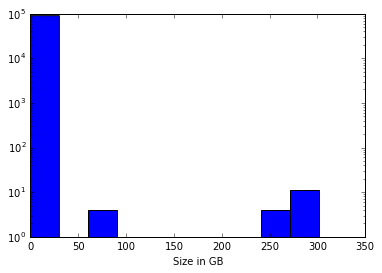

In [13]:
#Make some plots
ax = plt.hist(pddir["size"]/(1024.*1024.*1024))
plt.yscale('log')
plt.xlabel("Size in GB")